In [47]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd
from liesel.contrib.splines import equidistant_knots as kn
from liesel.contrib.splines import pspline_penalty

from liesel_gam import MultivariateNormalSingular
from liesel_gam.experimental.approx_bspline import BSplineApprox

In [48]:
x_loc_true = jax.random.uniform(jax.random.key(43), (100, 1), minval=-2.0, maxval=2.0)
dist = tfd.MultivariateNormalDiag(loc=x_loc_true, scale_diag=jnp.ones(5))
x = dist.sample(seed=jax.random.key(42))

knots = kn(jnp.array([-4.0, 4.0]), n_param=20)
bspline = BSplineApprox(knots)
coef = MultivariateNormalSingular(
    loc=jnp.zeros(20),
    scale=0.5,
    penalty=pspline_penalty(d=20),
    penalty_rank=18,
).sample(seed=jax.random.key(47))

obs_true = bspline.dot(x_loc_true[:, 0], coef)
obs_true

obs = obs_true + 0.1 * jax.random.normal(jax.random.key(45), (100,))

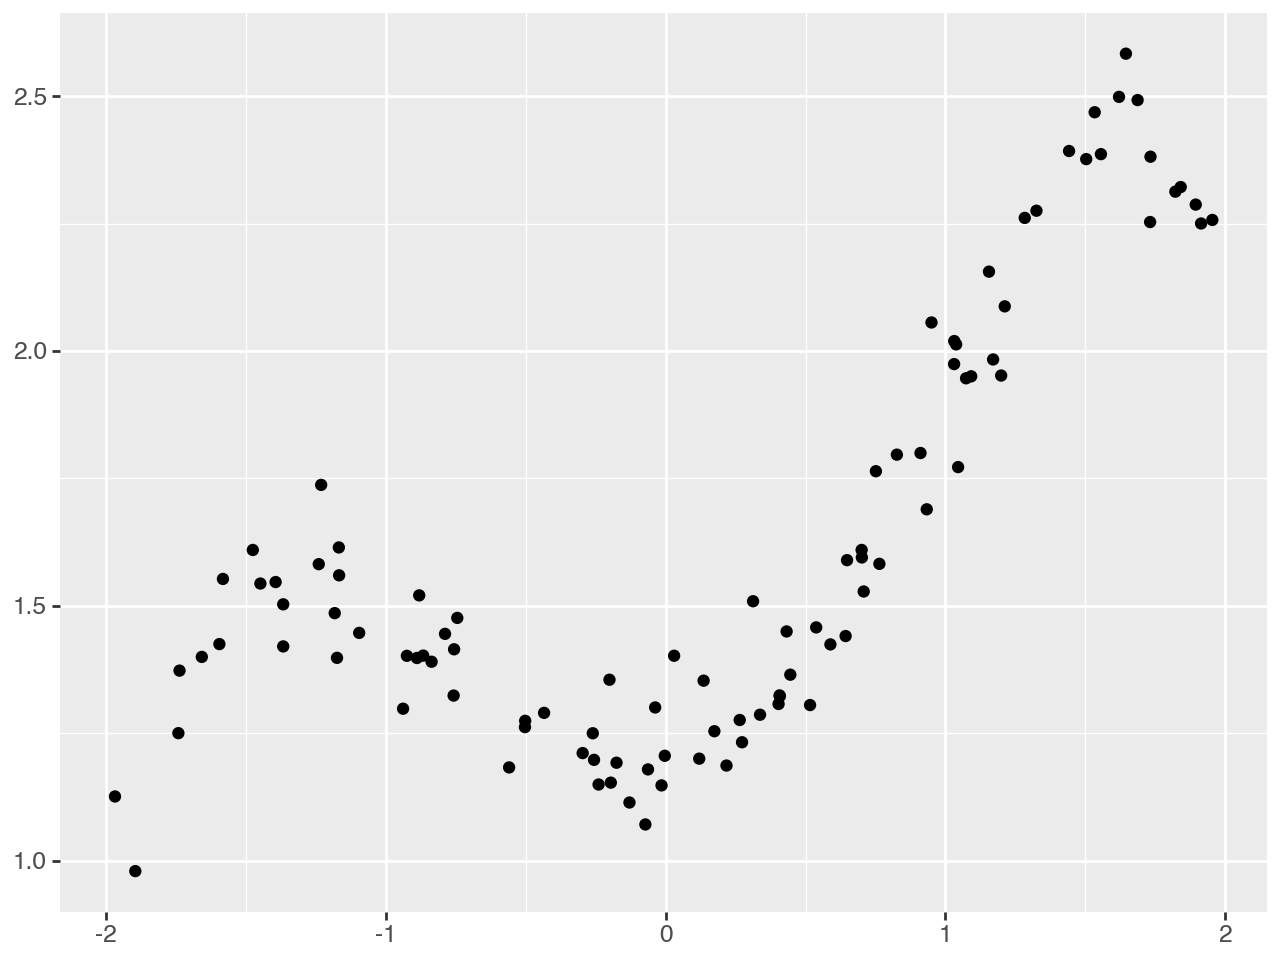

In [49]:
import plotnine as p9

(p9.ggplot() + p9.geom_point(p9.aes(x_loc_true[:, 0], obs)))

In [50]:
x.shape

(100, 5)

In [51]:
x_loc = lsl.Var.new_param(
    jnp.zeros((100, 1)),
    name="xloc",
    inference=gs.MCMCSpec(gs.HMCKernel),
)
x_scale = lsl.Var.new_param(
    1.0,
    name="xscale",
    bijector=tfb.Exp(),
    inference=gs.MCMCSpec(gs.HMCKernel),
)
x_var = lsl.Var.new_obs(
    value=x,
    distribution=lsl.Dist(tfd.Normal, loc=x_loc, scale=x_scale),
    name="x",
)

x_loc_vector = lsl.Calc(lambda x: jnp.atleast_1d(jnp.squeeze(x)), x_loc)

In [52]:
tau = lsl.Var.new_param(
    0.2,
    lsl.Dist(tfd.HalfNormal, scale=1.0),
    name="tau",
    bijector=tfb.Exp(),
    inference=gs.MCMCSpec(gs.IWLSKernel),
)
coef_var = lsl.Var.new_param(
    jnp.zeros(20),
    distribution=lsl.Dist(
        MultivariateNormalSingular,
        loc=jnp.zeros(20),
        scale=tau,
        penalty=pspline_penalty(d=20),
        penalty_rank=18,
    ),
    name="coef",
    inference=gs.MCMCSpec(gs.IWLSKernel),
)

bspline = BSplineApprox(knots)
fx_var = lsl.Var.new_calc(bspline.dot, x_loc_vector, coef_var, name="fx")

scale_var = lsl.Var.new_param(
    1.0,
    lsl.Dist(tfd.InverseGamma, concentration=0.01, scale=0.01),
    name="scale",
    inference=gs.MCMCSpec(gs.IWLSKernel),
)
obs_var = lsl.Var.new_obs(
    obs, lsl.Dist(tfd.Normal, loc=fx_var, scale=scale_var), name="obs"
)

model = lsl.Model([x_var, obs_var])

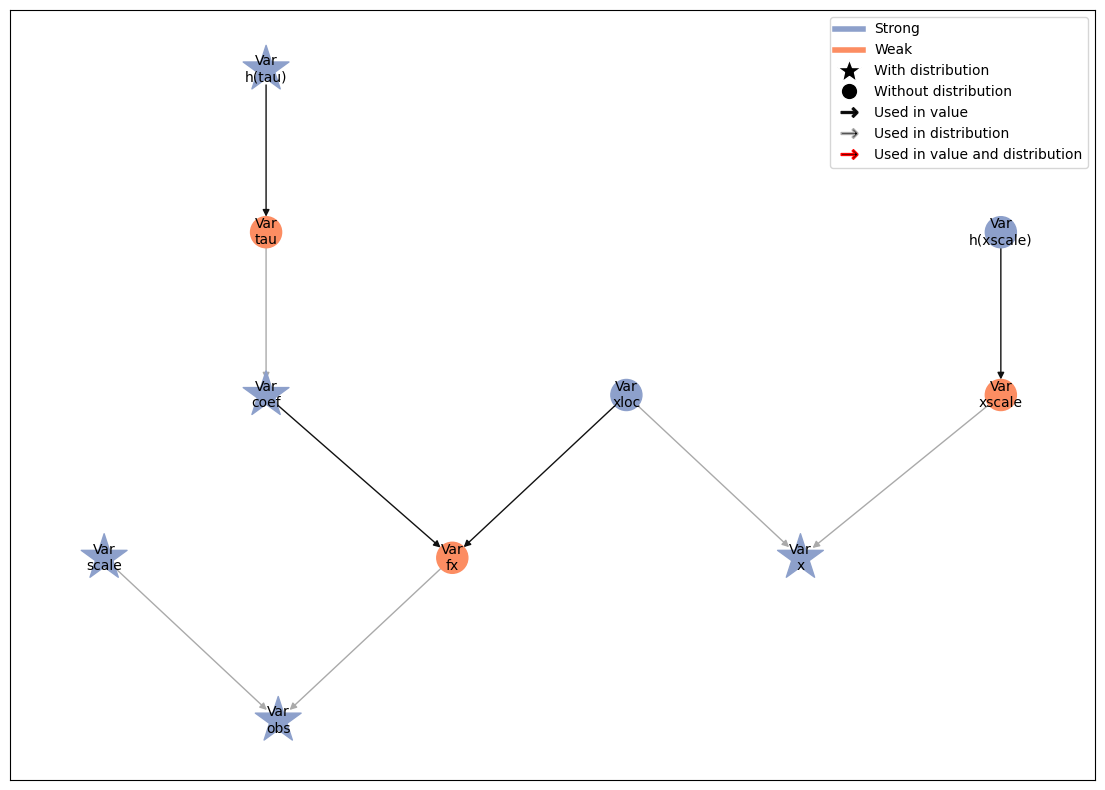

In [53]:
model.plot_vars()

In [54]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.add_adaptation(2000)
eb.add_posterior(2000)

engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys 'scale', 'coef', 'h(tau)', 'xloc', 'h(xscale)'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 200 transitions, 25 jitted together
100%|██████████████████████████████████████████| 8/8 [00:03<00:00,  2.60chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 89, 62, 35, 56 / 200 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 3, 3, 3, 4 / 200 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 19, 16, 22, 20 / 200 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1282.27chunk/s]
liesel.goose.engine - WARNING - Errors per ch

In [55]:
summary = gs.Summary(results)
summary

Parameter summary:

                      kernel      mean        sd    q_0.05     q_0.5  \
parameter index                                                        
coef      (0,)     kernel_01 -0.965055  2.296642 -5.069829 -0.777897   
          (1,)     kernel_01 -0.491576  1.637622 -3.457140 -0.342956   
          (2,)     kernel_01 -0.025274  1.070417 -1.980494  0.122191   
          (3,)     kernel_01  0.449554  0.598840 -0.668638  0.560558   
          (4,)     kernel_01  0.930985  0.302910  0.388378  0.973043   
...                      ...       ...       ...       ...       ...   
xloc      (95, 0)  kernel_03  0.857885  0.130364  0.644527  0.859065   
          (96, 0)  kernel_03 -0.037837  0.471470 -0.918328  0.106902   
          (97, 0)  kernel_03  1.287765  0.249882  1.021999  1.249195   
          (98, 0)  kernel_03  0.626301  0.166517  0.368087  0.637520   
          (99, 0)  kernel_03 -0.225084  0.357282 -0.822026 -0.202653   

                     q_0.95  sample_size     ess_bulk     ess_tail      rhat  
parameter index                                                               
coef      (0,)     2.516435         8000   612.246368   582.437260  1.009351  
          (1,)     1.891569         8000   547.390157   499.017450  1.010401  
          (2,)     1.450241         8000   470.324957   429.116942  1.012979  
          (3,)     1.176149         8000   276.911148   510.343953  1.012166  
          (4,)     1.337450         8000    82.734286   194.841716  1.029495  
...                     ...          ...          ...          ...       ...  
xloc      (95, 0)  1.073246         8000   251.490075   993.088456  1.015127  
          (96, 0)  0.537774         8000   371.892283   565.607875  1.009506  
          (97, 0)  1.625504         8000   203.614654   223.163216  1.021365  
          (98, 0)  0.859146         8000   411.272578   954.046698  1.009477  
          (99, 0)  0.317251         8000  2967.074619  3727.287376  1.002804  

[123 rows x 10 columns]

Error summary:

                                                                                  count  \
kernel    error_code error_msg                                          phase             
kernel_00 2          indefinite information matrix (fallback to iden... warmup      243   
                                                                        posterior     0   
          90         nan acceptance prob                                warmup       21   
                                                                        posterior     0   
          92         indefinite information matrix (fallback to iden... warmup        2   
                                                                        posterior     0   
kernel_02 90         nan acceptance prob                                warmup        1   
                                                                        posterior     0   
kernel_03 1          divergent transition                               warmup      176   
                                                                        posterior   105   
kernel_04 1          divergent transition                               warmup      520   
                                                                        posterior     0   

                                                                                  sample_size  \
kernel    error_code error_msg                                          phase                   
kernel_00 2          indefinite information matrix (fallback to iden... warmup           8000   
                                                                        posterior        8000   
          90         nan acceptance prob                                warmup           8000   
                                                                        posterior        8000   
          92         indefinite information matrix (fallback to iden... warmup           8000   
                    

In [56]:
samples = results.get_posterior_samples()

In [57]:
fx_samp = fx_var.predict(samples)
x_loc_samp = x_loc.predict(samples)

In [58]:
fx_summary = gs.SamplesSummary.from_array(fx_samp).to_dataframe().reset_index()
x_loc_summary = gs.SamplesSummary.from_array(x_loc_samp).to_dataframe().reset_index()

In [59]:
fx_summary["x_true"] = x_loc_true
fx_summary["x_loc"] = x_loc_summary["mean"]
fx_summary["fx_true"] = obs_true

In [60]:
import plotnine as p9

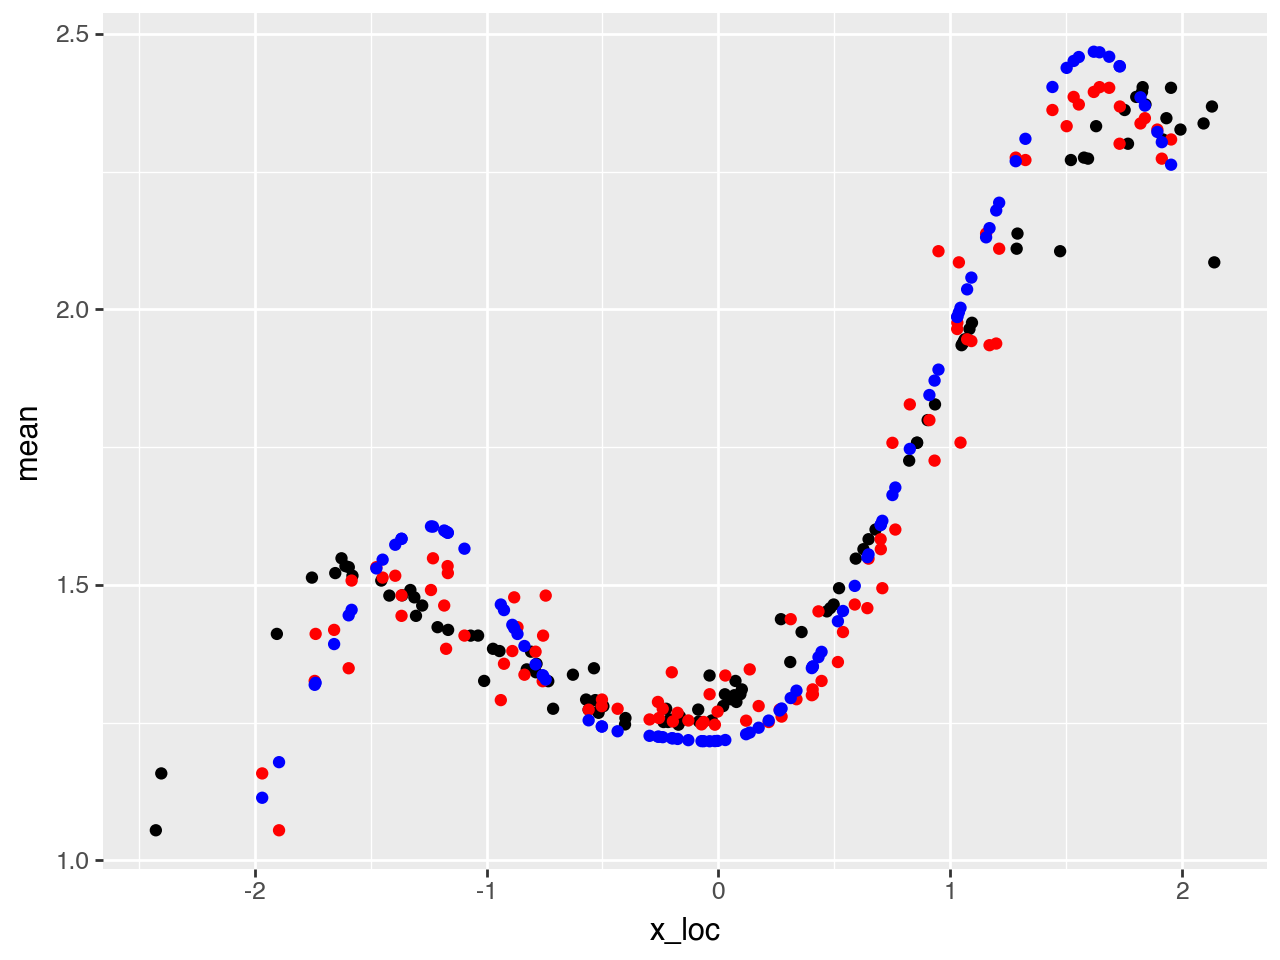

In [61]:
(
    p9.ggplot(fx_summary)
    + p9.geom_point(p9.aes("x_loc", "mean"))
    + p9.geom_point(p9.aes("x_true", "mean"), color="red")
    + p9.geom_point(p9.aes("x_true", "fx_true"), color="blue")
)